# **TP06 - Árboles de decisión**

In [1]:
#librerias
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import resample
from scipy.stats import mode

In [2]:
# 1. Cargamos el dataset
wine = load_wine()

#separamos los datos y las etiquetas
X = wine.data
y = wine.target

#obtenemos los nombres de los features y de las clases 
feature_names = wine.feature_names
target_names = wine.target_names


## Árboles de Decisión CART

Los árboles de decisión son modelos predictivos que se utilizan en el campo del aprendizaje automático y la estadística. Su estructura en forma de árbol permite representar de manera intuitiva un conjunto de reglas de decisión basadas en las características de los datos. El método CART (Classification and Regression Trees), es una técnica específica para la construcción de árboles de decisión que puede aplicarse tanto a problemas de clasificación como de regresión.

Los elementos de un árbol de decisión CART son:

- Nodo raíz: Es el punto de partida del árbol, donde se realiza la primera división de los datos.
- Nodos internos: Representan decisiones basadas en condiciones sobre las variables predictoras.
- Ramas: Conectan los nodos y representan los resultados de las decisiones.
- Nodos hoja: Corresponden a las salidas finales del modelo. En clasificación, contienen una clase; en regresión, un valor numérico estimado.

El método CART construye el árbol mediante un proceso recursivo de división binaria. Para cada división, se selecciona la variable y el punto de corte que mejor separan los datos, según un criterio de impureza o error:

- En clasificación, se utiliza típicamente el índice de Gini o la entropía para medir la pureza de los nodos.
- En regresión, se minimiza el error cuadrático medio (MSE).

El proceso continúa hasta que se cumple alguna condición de parada como:
- Todas las observaciones tienen la misma etiqueta.
- Si la rama tiene menos de un número preestablecido de observaciones.

---

En este trabajo, dado que se quiere clasificar el productor del cual proviene el vino, vamos a utilizar el método con las funciones de impurezas adecuadas para un problema de clasificación.

En un nodo $ m $, que representa una región $ R_m $ con $ N_m $ observaciones, la proporción de observaciones de clase $ k $ se define como:

$$
\hat{p}_{mk} = \frac{1}{N_m} \sum_{x_i \in R_m} I(y_i = k)
$$

Donde $ I(y_i = k) $ es la función indicadora que vale 1 si la observación $ y_i $ pertenece a la clase $ k $, y 0 en caso contrario.

A partir de esto, se pueden definir diferentes funciones de impureza $ H_m(T) $ para clasificación:

- **Índice de Gini (Gini index):**

$$
\text{Gini} = \sum_{k \ne k'} \hat{p}_{mk} \hat{p}_{mk'} = \sum_{k=1}^K \hat{p}_{mk} (1 - \hat{p}_{mk})
$$

- **Entropía Cruzada (Cross-entropy):**

$$
\text{Entropía} = -\sum_{k=1}^K \hat{p}_{mk} \log_2 (\hat{p}_{mk})
$$


El índice de Gini mide cuán probable es que una observación seleccionada al azar sea mal clasificada, asumiendo que se la clasifica aleatoriamente según la distribución de clases del nodo. Un nodo completamente puro (todas las observaciones pertenecen a la misma clase) tiene un índice de Gini igual a 0. A medida que el nodo contiene una mezcla más balanceada de clases, el valor del índice aumenta. El índice de Gini es eficiente computacionalmente.

Por otro lado, la entropía cruzada, mide el grado de desorden o incertidumbre de las clases en un nodo. También alcanza un valor de 0 cuando el nodo es puro, pero penaliza más fuertemente las distribuciones con clases poco frecuentes. Es decir, es más sensible que el índice de Gini a los cambios en la distribución de clases. La entropía cruzada tiende a generar divisiones más equilibradas cuando hay clases poco representadas.

---

### **Implementación**

Para poder implementar el árbol de decisión, vamos a utilizar `DecisionTreeClassifier` de la librería `sklearn`. Para este modelo queremos utilizar como función de impurezas, la entropía cruzada, por lo tanto, a la hora de inicializar la clase. debemos setear el párametro `criterior = "entropy"`.

Una vez que tenemos el modelo, lo entrenamos con el método `fit` pasando como argumento los datos `X` y las etiquetas `y`.

Para graficar el diagrama de árbol, utilizamos el método `plot_tree`, pasando como argumentos, el modelo, los nombres de los features y los nombres de las clases.

Luego con `clf.tree_.node_count` podemos obtener la cantidad de nodos del árbol; y con `sum(clf.tree_.children_left == -1)` podemos obtener la cantidad de hojas del árbol (los nodos tiene un atributo `children_left` y `children_right`, cuando un nodo es "hoja", ambos atributos valen `-1` ).




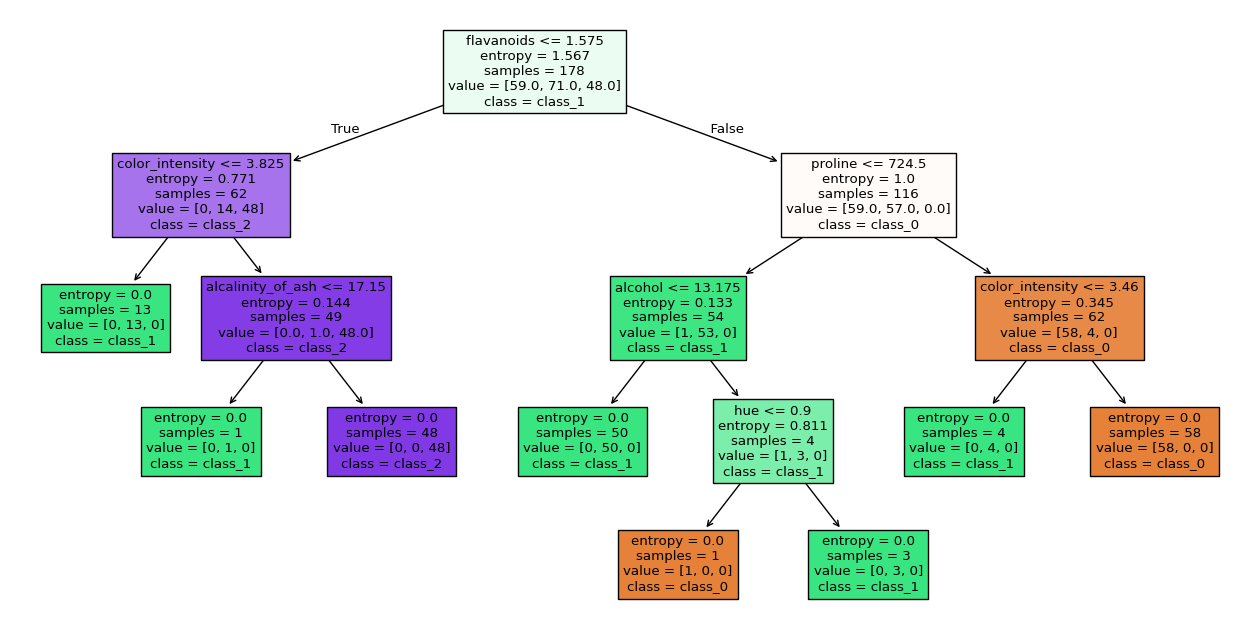

Número total de nodos: 15
Número total de hojas: 8
Top 3 características más importantes:
- flavanoids: 0.4128
- proline: 0.3134
- color_intensity: 0.2228

La muestra fue clasificada como clase: class_0


In [3]:
# generamos y entrenamos el árbol de decisión con criterio "entropy"
clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
clf.fit(X, y)

# Graficamos el árbol
plt.figure(figsize=(16, 8))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=target_names)
plt.show()

#obtenemos la cantidad de nodos y hojas
n_nodos = clf.tree_.node_count
n_hojas = sum(clf.tree_.children_left == -1)
print(f"Número total de nodos: {n_nodos}")
print(f"Número total de hojas: {n_hojas}")

#  Mostramos las 3 características más importantes
importances = clf.feature_importances_
top_indices = np.argsort(importances)[::-1][:3]  # índices de las 3 más importantes

print("Top 3 características más importantes:")
for idx in top_indices:
    print(f"- {feature_names[idx]}: {importances[idx]:.4f}")

# 6. Clasificamos la nueva muestra
muestra = np.array([[13.0, 2.33, 2.37, 19.5, 99.7, 2.29, 2.03, 0.36, 1.59, 5.06, 0.96, 2.61, 747]])
prediccion = clf.predict(muestra)
print(f"\nLa muestra fue clasificada como clase: {target_names[prediccion[0]]}")


## **Árbol podado**

Un árbol podado es una versión simplificada de un árbol de decisión que ha sido reducido mediante la eliminación de ramas que aportan poca o ninguna mejora en la capacidad predictiva del modelo. El objetivo principal de la poda es evitar el overfitting, que ocurre cuando el árbol se adapta demasiado a los datos de entrenamiento, perdiendo capacidad de generalización.

La técnica de poda que vamos a utilizar en nuestro caso es la poda basada en costo-complejidad, empleada por el algoritmo CART. Esta técnica evalúa un conjunto de árboles podados mediante una función de costo definida como:

$$
H_\alpha(T) = \sum_{m \in L(T)} \frac{|Q_m|}{n} \cdot H(Q_m) + \alpha \cdot |L(T)|
$$

Donde:
- $ |Q_m| $ es la cantidad de muestras en la hoja $ m $,
- $ n $ es el número total de observaciones,
- $ H(Q_m) $ es la medida de impureza del nodo $ m $ (como entropía o índice de Gini),
- $ |L(T)| $ es el número total de hojas del árbol.



La poda se realiza seleccionando el subárbol que minimiza esta medida, logrando así un compromiso entre el ajuste a los datos (primer término) y la simplicidad del modelo (segundo término penalizado por $ \alpha $).

---

### **Implementación**

Para implementar el árbol de decisión podado, vamos a utilizar nuevamente `DecisionTreeClassifier` con entropía cruzada como función de impurezas y con un `alpha` de $0.05$ (para ello se setea el parámetro `cpp_alpha = 0.05`).

Luego se realiza lo mismo que para el caso anterior (entrenar el modelo, graficar el árbol, informar la cantidad de hojas y nodos, predecir la muestra).


Para 


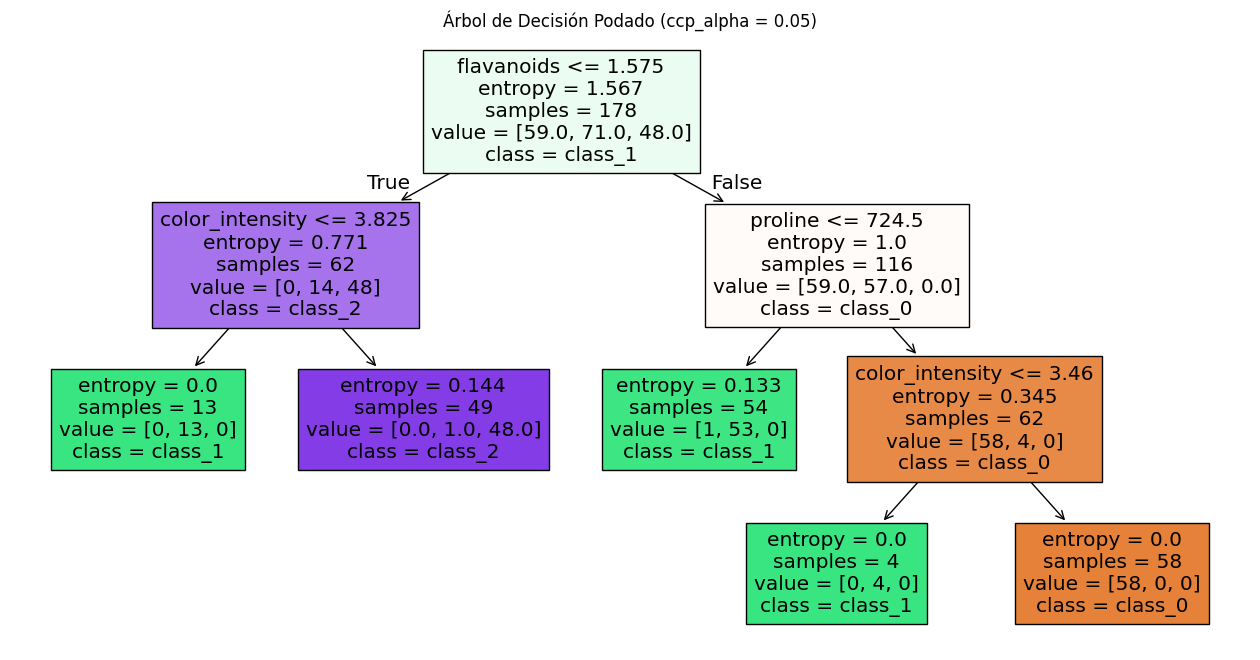

Número total de nodos: 9
Número total de hojas: 5
Top 3 características más importantes:
- flavanoids: 0.4350
- proline: 0.3302
- color_intensity: 0.2348

La muestra fue clasificada como clase: class_0

Costo-complejidad teórica del árbol podado: 0.3299


In [4]:
# Entrenar árbol con poda (ccp_alpha = 0.05)
clf_podado = DecisionTreeClassifier(criterion="entropy", ccp_alpha=0.05, random_state=42)
clf_podado.fit(X, y)

# Graficar el árbol podado
plt.figure(figsize=(16, 8))
plot_tree(clf_podado, filled=True, feature_names=feature_names, class_names=target_names)
plt.title("Árbol de Decisión Podado (ccp_alpha = 0.05)")
plt.show()

# Cantidad de nodos y hojas
n_nodos = clf_podado.tree_.node_count
n_hojas = sum(clf_podado.tree_.children_left == -1)
print(f"Número total de nodos: {n_nodos}")
print(f"Número total de hojas: {n_hojas}")

# Mostrar las 3 características más importantes
importances = clf_podado.feature_importances_
top_indices = np.argsort(importances)[::-1][:3]

print("Top 3 características más importantes:")
for idx in top_indices:
    print(f"- {feature_names[idx]}: {importances[idx]:.4f}")

# Clasificar la muestra dada
nueva_muestra = np.array([[13.0, 2.33, 2.37, 19.5, 99.7, 2.29, 2.03, 0.36, 1.59, 5.06, 0.96, 2.61, 747]])
prediccion = clf_podado.predict(nueva_muestra)
print(f"\nLa muestra fue clasificada como clase: {target_names[prediccion[0]]}")

# -----------------------------
# Calcular la medida de costo-complejidad teórica
# -----------------------------
# Obtener el árbol
tree = clf_podado.tree_
alpha = 0.05  # parámetro de complejidad
n_samples = tree.n_node_samples[0]  # total de muestras en la raíz

# Encontrar nodos hoja
hojas = tree.children_left == -1

# Calcular H_alpha(T)
suma_impurezas_ponderadas = 0
for i in range(tree.node_count):
    if hojas[i]:
        n_m = tree.n_node_samples[i]
        H_Qm = tree.impurity[i]
        suma_impurezas_ponderadas += (n_m / n_samples) * H_Qm

costo_complejidad = suma_impurezas_ponderadas + alpha * n_hojas
print(f"\nCosto-complejidad teórica del árbol podado: {costo_complejidad:.4f}")



# **Bosques Aleatorios(Random Forest)**

Los bosques aleatorios (Random Forest) son un método que consiste en múltiples árboles de decisión, diseñado para reducir el problema de overfitting característico de los árboles individuales. Si bien existen técnicas como la poda o los criterios de parada que ayudan a mitigarlo, no siempre son suficientes. Por eso, se introduce el método Bagging (Bootstrap Aggregating), que consiste en entrenar múltiples modelos sobre subconjuntos del conjunto de datos original y combinar sus salidas, mediante promedio (para regresión) o votación mayoritaria (para clasificación).

In [5]:

class RandomForest:
    def __init__(self, n_trees=30, max_features='sqrt', criterion='entropy', random_state=None):
        self.n_trees = n_trees
        self.max_features = max_features
        self.criterion = criterion
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []

        for i in range(self.n_trees):
            # Bootstrap sample
            X_sample, y_sample = resample(X, y, replace=True, random_state=self.random_state+i)

            # Crear y entrenar árbol
            tree = DecisionTreeClassifier(criterion=self.criterion,
                                          max_features=self.max_features,
                                          random_state=self.random_state+i)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Predecir con cada árbol
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        
        # Hard voting (modo)
        y_pred, _ = mode(all_preds, axis=0, keepdims=False)
        return y_pred


# Crear y entrenar el Random Forest
rf = RandomForest(n_trees=30, random_state=42)
rf.fit(X, y)

pred = rf.predict(muestra)
print(f"\nLa muestra fue clasificada como clase: {target_names[pred[0]]}")



La muestra fue clasificada como clase: class_0
